In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.core.display import display
from scipy.io import wavfile
import scipy


# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split, KFold

# Performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# LSTM
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, MaxPool2D, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy

# import tensorflow_io as tfio

/var/folders/gp/1_dqbwsn08sbtf7s0k5q2lsc0000gn/T/ipykernel_71090/4222563939.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
import os
import os
import sys
import shutil
import librosa
import pickle

In [4]:
CURR_DIR = os.getcwd()

# Utilities

In [5]:
DATA_DIR = os.path.join(CURR_DIR, "Crema")

### Resample waveform to 16k

In [6]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

### Function to load audio files

In [ ]:
@tf.function
def load_wavfile(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Data Exploration

### Happy

Sample rate: 16000 Hz
Total duration: 3.52s
Size of the input: 56287


/var/folders/gp/1_dqbwsn08sbtf7s0k5q2lsc0000gn/T/ipykernel_59475/788395808.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav_data = wavfile.read(file_path, 'rb')


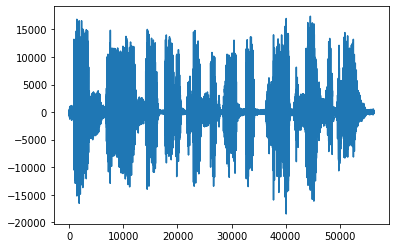

In [89]:
# wav_file_name = 'speech_whistling2.wav'
category = "happy"
wav_file_name = '2c9c46babe.wav'

file_path = os.path.join(DATA_DIR, category, wav_file_name)

sample_rate, wav_data = wavfile.read(file_path, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)
plt.plot(wav_data)

### Sad

Sample rate: 16000 Hz
Total duration: 2.17s
Size of the input: 34790


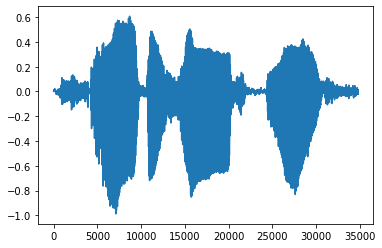

In [14]:
# wav_file_name = 'speech_whistling2.wav'
category = "sad"
wav_file_name = '1ac2b3d011.wav'

file_path = os.path.join(DATA_DIR, category, wav_file_name)

sample_rate, wav_data = wavfile.read(file_path, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)
plt.plot(wav_data)

### Neutral

Sample rate: 16000 Hz
Total duration: 2.11s
Size of the input: 33717


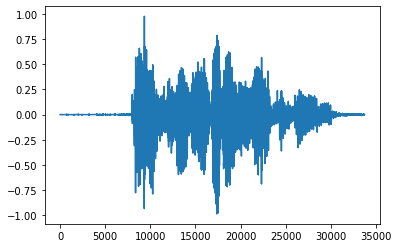

In [15]:
# wav_file_name = 'speech_whistling2.wav'
category = "neutral"
wav_file_name = '3a49f17ceb.wav'

file_path = os.path.join(DATA_DIR, category, wav_file_name)

sample_rate, wav_data = wavfile.read(file_path, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)
plt.plot(wav_data)

### Fear

Sample rate: 16000 Hz
Total duration: 1.74s
Size of the input: 27816


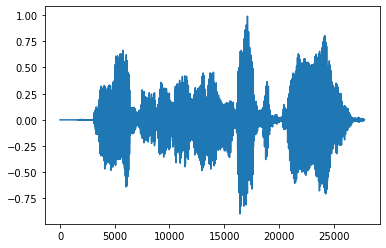

In [16]:
# wav_file_name = 'speech_whistling2.wav'
category = "fear"
wav_file_name = '0ef63f4364.wav'

file_path = os.path.join(DATA_DIR, category, wav_file_name)

sample_rate, wav_data = wavfile.read(file_path, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)
plt.plot(wav_data)

# Recording the files

In [8]:
ext_to_category = {
    "SAD": "sadness",
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fear",
    "HAP": "happy",
    "NEU": "neutral"
}

In [13]:
rows = []
for file in os.listdir(DATA_DIR):
    if file.startswith("."):
        continue

    file_path = os.path.join(DATA_DIR, file)        
    rel_file_path = os.path.relpath(file_path)

    tmp = rel_file_path.split("_")[2]
    category = ext_to_category[tmp]

    row = {
        "file": file,
        "file_path": rel_file_path, 
        "label": category
    }

    rows.append(row)


# categories

In [14]:
# rows = []

# for category in categories[:]:
#     CATEGORY_DIR = os.path.join(DATA_DIR, category)

#     for file in os.listdir(CATEGORY_DIR):
#         if file.startswith("."):
#             continue

#         file_path = os.path.join(CATEGORY_DIR, file)        
#         rel_file_path = os.path.relpath(file_path)

#         row = {
#             "file": file,
#             "file_path": rel_file_path, 
#             "label": category
#         }
    
#         rows.append(row)


In [15]:
df = pd.DataFrame(rows)

In [16]:
df.head()

,file,file_path,label
0,1022_ITS_ANG_XX.wav,Crema/1022_ITS_ANG_XX.wav,angry
1,1037_ITS_ANG_XX.wav,Crema/1037_ITS_ANG_XX.wav,angry
2,1060_ITS_NEU_XX.wav,Crema/1060_ITS_NEU_XX.wav,neutral
3,1075_ITS_NEU_XX.wav,Crema/1075_ITS_NEU_XX.wav,neutral
4,1073_IOM_DIS_XX.wav,Crema/1073_IOM_DIS_XX.wav,disgust


In [17]:
df.describe()

,file,file_path,label
count,7442,7442,7442
unique,7442,7442,6
top,1022_ITS_ANG_XX.wav,Crema/1022_ITS_ANG_XX.wav,angry
freq,1,1,1271


In [18]:
df.isna().sum()

file         0
file_path    0
label        0
dtype: int64

In [20]:
# # Save datafram
# df.to_csv("crema_dataset_meta.csv", index=False)

# Data Preprocessing

In [19]:
waveform = wav_data / tf.int16.max

In [39]:
# label_to_target = {
#     "sad": 0,
#     "fear": 1,
#     "angry": 2,
#     "neutral": 3, 
#     "happy": 4
# }

label_to_target = {
    "sadness": 0,
    "fear": 1,
    "angry": 2,
    "disgust": 3,
    "neutral": 4, 
    "happy": 5
}

In [40]:
# Read the meta data
df = pd.read_csv("crema_dataset_meta.csv")
print(len(df))
df.head()

7442


,file,file_path,label
0,1022_ITS_ANG_XX.wav,Crema/1022_ITS_ANG_XX.wav,angry
1,1037_ITS_ANG_XX.wav,Crema/1037_ITS_ANG_XX.wav,angry
2,1060_ITS_NEU_XX.wav,Crema/1060_ITS_NEU_XX.wav,neutral
3,1075_ITS_NEU_XX.wav,Crema/1075_ITS_NEU_XX.wav,neutral
4,1073_IOM_DIS_XX.wav,Crema/1073_IOM_DIS_XX.wav,disgust


In [41]:
df['target'] = df['label'].apply(lambda x: label_to_target[x])

In [42]:
df['target']

0       2
1       2
2       4
3       4
4       3
       ..
7437    2
7438    2
7439    2
7440    2
7441    4
Name: target, Length: 7442, dtype: int64

In [43]:
df.isna().sum()

file         0
file_path    0
label        0
target       0
dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df['file_path'], df['label'], test_size=0.2, random_state=42)

In [45]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [46]:
# Save train and test
df_train.to_csv("crema_df_train.csv", index=False)
df_test.to_csv("crema_df_test.csv", index=False)

### Manual processing

In [94]:
def load_audio(file_path, label):
    # file_path_str = bytes.decode(file_path.numpy())
    # print(file_path_str)
    sample_rate, wav_data = wavfile.read(file_path, 'rb')
    sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

    # # Normalise wave data
    # wav_data = wav_data / tf.int16.max

    # Convert to tensor
    wav_data_tensor = tf.convert_to_tensor(wav_data, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.int64)
    return (wav_data_tensor, label_tensor)

In [95]:
# Load the model.
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

2023-04-07 02:37:01.559904: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-07 02:37:01.569217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-07 02:37:01.575073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In 

In [96]:
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))


In [90]:
scores, embeddings, spectrogram = yamnet_model(wav_data)

In [97]:
train_ls = []

In [98]:
for file_path, label in list(zip(X_train, y_train)):
    wav_data_tensor, label_tensor = load_audio(file_path, label)
    train_ls.append((wav_data_tensor, label_tensor))

In [99]:
train_embedding_tensor_ls = []

In [101]:
for wave, label in train_ls:
    scores, embeddings, spectrogram = yamnet_model(wave)
    for embedding in embeddings:
        train_embedding_tensor_ls.append((embedding, label))

In [95]:
# train_wave_tensor_ds = tf.concat(train_ls, axis=0)

In [108]:
# # Save train_embedding_tensor_ls
# with open("crema_train_embeeding_tensor_ls.pkl", "wb") as file:
#     pickle.dump(train_embedding_tensor_ls, file)

In [109]:
# Load train_embedding_tensor_ls
with open("crema_train_embeeding_tensor_ls.pkl", "rb") as file:
    train_embedding_tensor_ls = pickle.load(file)

In [102]:
len(train_embedding_tensor_ls)

28435

In [103]:
test_ls = []

In [104]:
for file_path, label in list(zip(X_test, y_test)):
    wav_data_tensor, label_tensor = load_audio(file_path, label)
    test_ls.append((wav_data_tensor, label_tensor))

In [105]:
test_embedding_tensor_ls = []

In [106]:
for wave, label in test_ls:
    scores, embeddings, spectrogram = yamnet_model(wave)
    for embedding in embeddings:
        test_embedding_tensor_ls.append((embedding, label))

In [110]:
# # Save train_embedding_tensor_ls
# with open("crema_test_embeeding_tensor_ls.pkl", "wb") as file:
#     pickle.dump(test_embedding_tensor_ls, file)

In [111]:
# Load train_embedding_tensor_ls
with open("crema_test_embeeding_tensor_ls.pkl", "rb") as file:
    test_embedding_tensor_ls = pickle.load(file)

In [112]:
len(test_embedding_tensor_ls)

7117

#### Convert to numpy

In [135]:
tf.concat(test_embedding_tensor_ls, axis=0)

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a float tensor but is a int64 tensor [Op:Pack] name: packed

In [127]:
temp = []

In [113]:
train_tensor = []
train_labels = []
for tensor, label in train_embedding_tensor_ls:
    # np_array = tensor.numpy()
    train_tensor.append(tensor)
    train_labels.append(label)


In [123]:
train_dataset = tf.data.Dataset.from_tensors((train_tensor, train_labels))

In [115]:
test_tensor = []
test_labels = []
for tensor, label in test_embedding_tensor_ls:
    # np_array = tensor.numpy()
    test_tensor.append(tensor)
    test_labels.append(label)


In [124]:
test_dataset = tf.data.Dataset.from_tensors((test_tensor, test_labels))

In [128]:

counter = 0 
for embedding, label in train_dataset:
    if counter > 5:
        break
    
    print(embedding.shape, label)

    counter += 1
    

(28435, 1024) tf.Tensor([0 0 0 ... 1 1 1], shape=(28435,), dtype=int64)


In [129]:
train_dataset

<TensorDataset shapes: ((28435, 1024), (28435,)), types: (tf.float32, tf.int64)>

# Training Model v2

In [133]:
# class Model(tf.Module):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.dense1 = tf.keras.layers

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6)
], name='my_model')

model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 774       
Total params: 591,238
Trainable params: 591,238
Non-trainable params: 0
_________________________________________________________________


In [134]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5,
                                            restore_best_weights=True)

save_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_2/model.epoch{epoch:02d}.hdf5',
    monitor ='val_loss',
    verbose = 1,
    save_best_only = True,
)

callbacks = [early_stop, save_model_checkpoint]

In [135]:
history = model.fit(train_dataset,
                       epochs=20,
                       validation_data=test_dataset,
                       callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 4.8259 - accuracy: 0.1710 - val_loss: 5.7505 - val_accuracy: 0.2119

Epoch 00001: val_loss improved from inf to 5.75052, saving model to model_2/model.epoch01.hdf5
Epoch 2/20
1/1 [==============================] - 1s 652ms/step - loss: 5.5662 - accuracy: 0.2103 - val_loss: 7.3938 - val_accuracy: 0.2620

Epoch 00002: val_loss did not improve from 5.75052
Epoch 3/20
1/1 [==============================] - 1s 646ms/step - loss: 6.9839 - accuracy: 0.2589 - val_loss: 7.0580 - val_accuracy: 0.2640

Epoch 00003: val_loss did not improve from 5.75052
Epoch 4/20
1/1 [==============================] - 1s 651ms/step - loss: 6.6330 - accuracy: 0.2676 - val_loss: 7.3457 - val_accuracy: 0.1987

Epoch 00004: val_loss did not improve from 5.75052
Epoch 5/20
1/1 [==============================] - 1s 649ms/step - loss: 6.9265 - accuracy: 0.2017 - val_loss: 7.3177 - val_accuracy: 0.2021

Epoch 00005: val_loss did not improve from 5.75052

# Training MOdel v1

In [ ]:
# train_wave_tensor_ds = tf.concat(train_ls, axis=0)

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a float tensor but is a int64 tensor [Op:Pack] name: packed

In [ ]:
# Save train_embedding_tensor_ls
with open("train_embeeding_tensor_ls.pkl", "wb") as file:
    pickle.dump(train_embedding_tensor_ls, file)

In [84]:
tf.convert_to_tensor(train_ls)

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a float tensor but is a int64 tensor [Op:Pack] name: 0

In [92]:
test_ls = []

In [93]:
for file_path, label in list(zip(X_train, y_train)):
    wav_data_tensor, label_tensor = load_audio(file_path, label)
    train_ls.append((wav_data_tensor, label_tensor))

AttributeError: 'str' object has no attribute 'numpy'

In [ ]:
train_wave_tensor_ds = tf.concat(train_ls, axis=0)

InvalidArgumentError: OpKernel 'ConcatV2' has constraint on attr 'T' not in NodeDef '[N=0, Tidx=DT_INT32]', KernelDef: 'op: "ConcatV2" device_type: "CPU" constraint { name: "T" allowed_values { list { type: DT_UINT64 } } } host_memory_arg: "axis"' [Op:ConcatV2] name: concat

In [22]:
# Save wave 
with open("train_wave_tensor", "wb") as file:
    pickle.dump(train_ls, file)

In [19]:
train_ls[2][1].numpy()

2

In [12]:
# # Save the train and test set
# df_train = pd.concat([X_train, y_train], axis=1)
# print(df_train.head())

# df_train.to_csv("df_train.csv", index=False)

# df_test = pd.concat([X_test, y_test], axis=1)
# print(df_test.head())

# df_test.to_csv("df_test.csv", index=False)

In [105]:
wav1 = tf.convert_to_tensor(wav_data)
wav2 = tf.convert_to_tensor(wav_data)

In [106]:
ls = [wav1, wav2]

In [107]:
waves = tf.stack(ls)

In [108]:
waves.shape

TensorShape([2, 27520])

In [109]:
X_train

2087      huge_collated_dataset/sad/sad_2_5_174_vesus.wav
5848    huge_collated_dataset/neutral/neutral_5_5_108_...
8532    huge_collated_dataset/angry/angry_7_6_78_vesus...
96      huge_collated_dataset/happy/happy_4_4_206_vesu...
5751    huge_collated_dataset/neutral/neutral_9_6_33_v...
                              ...                        
5734    huge_collated_dataset/neutral/neutral_1_3_229_...
5191    huge_collated_dataset/neutral/neutral_5_5_85_v...
5390    huge_collated_dataset/neutral/neutral_8_1_145_...
860     huge_collated_dataset/happy/happy_2_2_143_vesu...
7270    huge_collated_dataset/angry/angry_4_1_92_vesus...
Name: file_path, Length: 6861, dtype: object

# With Tensor Slices Pipeline

In [136]:
# label_to_target = {
#     "sad": 0,
#     "fear": 1,
#     "angry": 2,
#     "neutral": 3, 
#     "happy": 4
# }

label_to_target = {
    "sadness": 0,
    "fear": 1,
    "angry": 2,
    "disgust": 3,
    "neutral": 4, 
    "happy": 5
}

In [137]:
df_train = pd.read_csv("crema_df_train.csv")
df_test = pd.read_csv("crema_df_test.csv")

In [138]:
X_train = df_train['file_path'][:]
y_train = df_train['label'][:].apply(lambda x: label_to_target[x])
X_test = df_test['file_path']
y_test = df_test['label'].apply(lambda x: label_to_target[x])

In [139]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [140]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [141]:
# Helper load audio function
# @tf.function
def load_audio(file_path, label):
    file_path_str = bytes.decode(file_path.numpy())
    print(file_path_str, label)
    sample_rate, wav_data = wavfile.read(file_path_str, 'rb')
    sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

    # Normalise wave data
    wav_data = wav_data / tf.int16.max

    # Convert to tensor
    wav_data_tensor = tf.convert_to_tensor(wav_data, dtype=tf.float32)
    return (wav_data_tensor, label)

In [142]:
# train_audio_ds = train_ds.map(load_audio)

In [143]:
train_audio_ds = train_ds.map(lambda x, y: tf.py_function(load_audio, [x, y], [tf.float32, tf.int64]))
train_audio_ds

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int64)>

In [144]:
train_audio_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))

In [145]:
test_audio_ds = test_ds.map(lambda x, y: tf.py_function(load_audio, [x, y], [tf.float32, tf.int64]))
test_audio_ds

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int64)>

In [146]:
test_audio_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))

In [147]:
# for wave, target in train_audio_ds:
#     print(wave[:5])

# Transfer learning with YAMNet

In [148]:
# Load the model.
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [149]:
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))


In [150]:
main_ds = train_audio_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [151]:
val_ds = test_audio_ds.map(extract_embedding).unbatch()
val_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [152]:
# # Save the main_ds
# tf.data.experimental.save(main_ds, "./main_ds")

# # Save the val_ds
# tf.data.experimental.save(val_ds, "./val_ds")

In [153]:
main_train_ds = main_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
val_train_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Training the Model

In [154]:
# class Model(tf.Module):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.dense1 = tf.keras.layers

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6)
], name='my_model')

model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 774       
Total params: 591,238
Trainable params: 591,238
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 optimizer="adam",
                 metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

save_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_1/model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5',
    monitor ='val_loss',
    verbose = 1,
    save_best_only = True,
)

callbacks = [early_stop, save_model_checkpoint]

In [156]:
history = model.fit(main_train_ds,
                       epochs=20,
                       validation_data=val_train_ds,
                       callbacks=callbacks)

Epoch 1/20
Crema/1003_WSI_SAD_XX.wav tf.Tensor(0, shape=(), dtype=int64)
Crema/1047_IWW_NEU_XX.wav tf.Tensor(4, shape=(), dtype=int64)
Crema/1027_IWL_FEA_XX.wav tf.Tensor(1, shape=(), dtype=int64)
Crema/1053_ITS_FEA_XX.wav tf.Tensor(1, shape=(), dtype=int64)
Crema/1062_ITS_DIS_XX.wav tf.Tensor(3, shape=(), dtype=int64)
Crema/1017_IEO_DIS_HI.wav tf.Tensor(3, shape=(), dtype=int64)
Crema/1043_ITH_ANG_XX.wav tf.Tensor(2, shape=(), dtype=int64)
Crema/1053_TSI_HAP_XX.wav tf.Tensor(5, shape=(), dtype=int64)


      1/Unknown - 1s 539ms/step - loss: 7.2257 - accuracy: 0.3125Crema/1039_IWL_NEU_XX.wav tf.Tensor(4, shape=(), dtype=int64)
Crema/1052_ITS_SAD_XX.wav tf.Tensor(0, shape=(), dtype=int64)
Crema/1025_ITH_ANG_XX.wav tf.Tensor(2, shape=(), dtype=int64)
Crema/1084_IOM_DIS_XX.wav tf.Tensor(3, shape=(), dtype=int64)
Crema/1027_IEO_ANG_LO.wav tf.Tensor(2, shape=(), dtype=int64)
Crema/1015_IEO_DIS_HI.wav tf.Tensor(3, shape=(), dtype=int64)
Crema/1017_IOM_DIS_XX.wav tf.Tensor(3, shape=(), dtype=int64)
      2/Unknown - 1s 388ms/step - loss: 6.3677 - accuracy: 0.2734Crema/1079_IWW_SAD_XX.wav tf.Tensor(0, shape=(), dtype=int64)
Crema/1087_ITS_HAP_XX.wav tf.Tensor(5, shape=(), dtype=int64)
Crema/1047_WSI_FEA_XX.wav tf.Tensor(1, shape=(), dtype=int64)
Crema/1019_IEO_FEA_HI.wav tf.Tensor(1, shape=(), dtype=int64)
Crema/1061_IEO_FEA_MD.wav tf.Tensor(1, shape=(), dtype=int64)
Crema/1046_ITH_ANG_XX.wav tf.Tensor(2, shape=(), dtype=int64)
Crema/1041_TSI_ANG_XX.wav tf.Tensor(2, shape=(), dtype=int64)
Cr

# Saving the Model

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [84]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(wave_data)

NameError: name 'wave_data' is not defined

In [20]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

2023-04-06 19:28:21.324701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [85]:
embeddings

<tf.Tensor: shape=(3, 1024), dtype=float32, numpy=
array([[2.175924  , 0.3591828 , 0.5648943 , ..., 0.34278473, 2.2839918 ,
        3.6191835 ],
       [2.3264675 , 0.41704032, 0.45783436, ..., 0.33244064, 2.3892274 ,
        3.5955532 ],
       [2.0903363 , 0.34951845, 0.65777   , ..., 0.35120144, 2.218155  ,
        3.730153  ]], dtype=float32)>

In [21]:
embeddings

<tf.Tensor: shape=(3, 1024), dtype=float32, numpy=
array([[2.175924  , 0.3591828 , 0.5648943 , ..., 0.34278473, 2.2839918 ,
        3.6191835 ],
       [2.3264675 , 0.41704032, 0.45783436, ..., 0.33244064, 2.3892274 ,
        3.5955532 ],
       [2.0903363 , 0.34951845, 0.65777   , ..., 0.35120144, 2.218155  ,
        3.730153  ]], dtype=float32)>

# Visualisation

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))